In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

In [2]:
train = pd.read_csv('./dataset/label/public_training_data.csv')
valid = pd.read_csv('./dataset/label/public_validation_data.csv')
test= pd.read_csv('./dataset/label/public_testing_data.csv')

train.sort_values(by='filename',inplace=True)
valid.sort_values(by='filename',inplace=True)
test.sort_values(by='filename',inplace=True)

In [3]:
data_dir_train = Path('./dataset/modified_object_detection/public_training_data/')
data_dir_valid = Path('./dataset/non_modified/public_validation_data/')
data_dir_test = Path('./dataset/non_modified/public_testing_data/')

train['IMAGE'] = sorted(list(map(str, list(data_dir_train.glob('*.jpg')))))
valid['IMAGE'] = sorted(list(map(str, list(data_dir_valid.glob('*.jpg')))))
test['IMAGE'] = sorted(list(map(str, list(data_dir_test.glob('*.jpg')))))

In [4]:
train.dropna(axis=0,inplace=True)
valid.dropna(axis=0,inplace=True)
test.dropna(axis=0,inplace=True)

train = train[train['label'] != 'UNREADABLE']
valid = valid[valid['label'] != 'UNREADABLE']
test = test[test['label'] != 'UNREADABLE']

train.reset_index(inplace=True,drop=True)
valid.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

train['label'] = train['label'].str.upper()
valid['label'] = valid['label'].str.upper()
test['label'] = test['label'].str.upper()

train['Length']=train['label'].apply(lambda x : len(str(x)))
valid['Length']=valid['label'].apply(lambda x : len(str(x)))
test['Length']=test['label'].apply(lambda x : len(str(x)))

train = train[train['Length']<=21]
valid = valid[valid['Length']<=21]
test = test[test['Length']<=21]

In [5]:
train = train[:12000]
valid = valid[:6000]
test = test[:6000]
print(len(train))
print(len(valid))
print(len(test))

11841
6000
6000


In [6]:
images_train = train['IMAGE'].values
images_valid = valid['IMAGE'].values
images_test = test['IMAGE'].values

labels_train = []
labels_valid = []
labels_test = []

for i in train['label']:
    if len(i)<21:
        i+='#'*(21-len(i))
        labels_train.append(i)

for i in valid['label']:
    if len(i)<21:
        i+='#'*(21-len(i))
        labels_valid.append(i)
        
for i in test['label']:
    if len(i)<21:
        i+='#'*(21-len(i))
    labels_test.append(i)

#labels_train = train['IDENTITY']
#labels_valid = valid['IDENTITY']

characters = set(char for label in labels_train for char in label)

print("Number of train images found: ", len(images_train))
print("Number of train labels found: ", len(labels_train))

print("Number of validation images found: ", len(images_valid))
print("Number of validation labels found: ", len(labels_valid))

print("Number of test images found: ", len(images_test))
print("Number of test labels found: ", len(labels_test))

print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

img_width = 256
img_height = 64
batch_size = 128

downsample_factor = 4
max_length = 22

Number of train images found:  11841
Number of train labels found:  11841
Number of validation images found:  6000
Number of validation labels found:  6000
Number of test images found:  6000
Number of test labels found:  6000
Number of unique characters:  36
Characters present:  {'V', 'J', '1', '6', '4', 'E', 'W', 'S', '3', 'F', 'L', 'Q', '7', 'P', 'K', 'Y', 'D', 'M', 'G', 'B', '9', 'H', 'Z', ' ', '5', 'X', '#', '8', '0', 'U', 'N', 'C', '2', 'T', 'R', 'A'}


In [7]:
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary=sorted(list(characters)),
                                                             num_oov_indices=0,
                                                             mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                                             mask_token=None,
                                                             invert=True)

In [8]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #label = char_to_index(label)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((images_valid, labels_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

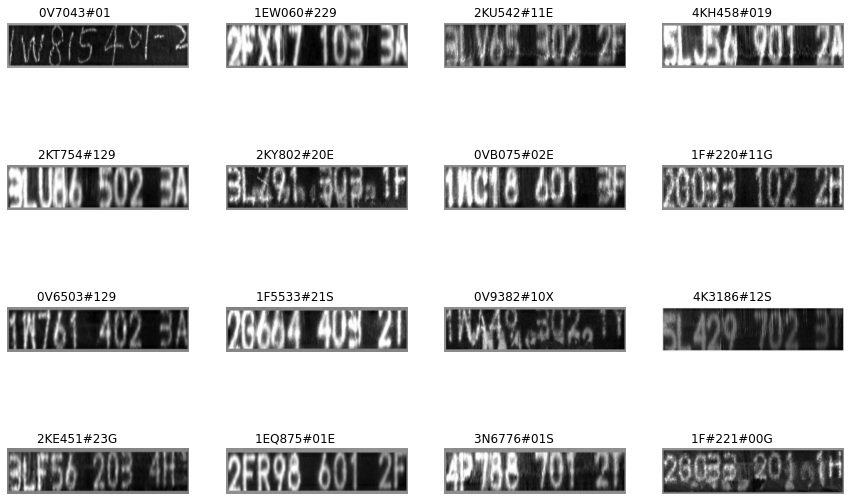

In [29]:
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [11]:
class CTCLayer(layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0] , dtype = 'int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype = 'int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')
        loss = self.loss_fn(y_true,y_pred,input_length,label_length)
        self.add_loss(loss)
        return y_pred

In [12]:
def build_model():
    inputs = keras.Input(shape=(img_width,img_height,1), name='image', dtype=tf.float32)
    labels = keras.Input(shape=(None,),name='label',dtype=tf.float32)

  # First Conv1 Block
    x = layers.Conv2D(64,
                    (3,3),
                    padding='same',
                    activation='relu',
                    kernel_initializer='he_normal',
                    name='Conv1')(inputs)
    x = layers.MaxPool2D((2,2),name='pool1')(x)
    x = layers.Dropout(0.2)(x)
  # Second Conv2 Block
    x = layers.Conv2D(128,
                    (3,3),
                    padding='same',
                    kernel_initializer='he_normal',
                    activation='relu',
                    name='Conv2')(x)
    x = layers.MaxPool2D((2,2),name='pool2')(x)
    x = layers.Dropout(0.2)(x)

    new_shape = ((img_width//4),(img_height//4)*128)
    x = layers.Reshape(target_shape=new_shape,name='reshape')(x)
    x = layers.Dense(64,activation='relu',name='dense1')(x)
    x = layers.Dropout(0.2)(x)

  #RNN
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True,dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64,return_sequences=True,dropout=0.25))(x)
    #多加
    x = layers.Bidirectional(layers.LSTM(32,return_sequences=True,dropout=0.25))(x)

    x = layers.Dense(len(characters)+1,activation='softmax',name='dense2')(x)

  # CTC Layer
    outputs = CTCLayer(name='ctc_loss')(labels,x)

  # model
    model = keras.models.Model(inputs=[inputs,labels], outputs=outputs, name='ocr_model_v1')

  # Optimizer
    optimizer = keras.optimizers.Adam()

  # compile model
    model.compile(optimizer=optimizer)

    return model

In [13]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 64, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 32, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 32, 64)  0           pool1[0][0]                      
_______________________________________________________________________________________

In [14]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size=batch_size,
                    epochs=epochs)
#                     callbacks=[early_stopping])

Epoch 1/100
93/93 [==============================] - 49s 295ms/step - loss: 51.3768 - val_loss: 33.3518
Epoch 2/100
93/93 [==============================] - 23s 247ms/step - loss: 29.9864 - val_loss: 27.9083
Epoch 3/100
93/93 [==============================] - 23s 247ms/step - loss: 26.6644 - val_loss: 25.4841
Epoch 4/100
93/93 [==============================] - 23s 247ms/step - loss: 24.5296 - val_loss: 24.3692
Epoch 5/100
93/93 [==============================] - 23s 248ms/step - loss: 23.2315 - val_loss: 24.5557
Epoch 6/100
93/93 [==============================] - 23s 248ms/step - loss: 22.4648 - val_loss: 25.3790
Epoch 7/100
93/93 [==============================] - 23s 248ms/step - loss: 21.9173 - val_loss: 25.3695
Epoch 8/100
93/93 [==============================] - 23s 247ms/step - loss: 21.3510 - val_loss: 26.8231
Epoch 9/100
93/93 [==============================] - 23s 247ms/step - loss: 20.7485 - val_loss: 24.2140
Epoch 10/100
93/93 [==============================] - 23s 248ms/

93/93 [==============================] - 23s 247ms/step - loss: 1.0853 - val_loss: 35.2606
Epoch 80/100
93/93 [==============================] - 23s 247ms/step - loss: 1.0961 - val_loss: 33.9800
Epoch 81/100
93/93 [==============================] - 23s 247ms/step - loss: 1.0702 - val_loss: 29.1728
Epoch 82/100
93/93 [==============================] - 23s 248ms/step - loss: 1.0025 - val_loss: 31.4685
Epoch 83/100
93/93 [==============================] - 23s 248ms/step - loss: 0.9958 - val_loss: 31.1125
Epoch 84/100
93/93 [==============================] - 23s 251ms/step - loss: 0.9447 - val_loss: 33.2351
Epoch 85/100
93/93 [==============================] - 26s 284ms/step - loss: 0.9604 - val_loss: 33.9305
Epoch 86/100
93/93 [==============================] - 28s 302ms/step - loss: 0.9300 - val_loss: 33.9926
Epoch 87/100
93/93 [==============================] - 29s 311ms/step - loss: 0.8943 - val_loss: 31.7088
Epoch 88/100
93/93 [==============================] - 28s 307ms/step - loss: 

In [16]:
model.save('./model/model_object_detection')

INFO:tensorflow:Assets written to: ./model/model_object_detection\assets


INFO:tensorflow:Assets written to: ./model/model_object_detection\assets


In [17]:
prediction_model = keras.models.Model(
    model.get_layer('image').input, model.get_layer('dense2').output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0     

In [18]:
prediction_model.save('./model/prediction_object_detection')

INFO:tensorflow:Assets written to: ./model/prediction_object_detection\assets


INFO:tensorflow:Assets written to: ./model/prediction_object_detection\assets


In [19]:
pred_model = keras.models.load_model('./model/prediction_object_detection',compile = False)
pred_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 256, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0     

In [22]:
def decode_batch_prediction(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0][:,:max_length]
    output_text = []

    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('UTF-8')
        res = res.split('#')[0]
        output_text.append(res)
    return output_text

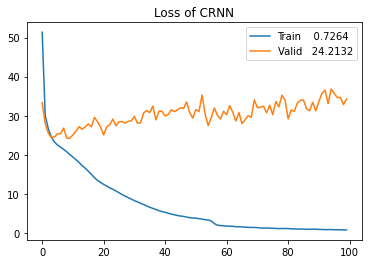

In [23]:
Train_Loss = history.history['loss']
Val_Loss = history.history['val_loss']
epochs_range = range(epochs)

plt.subplot( )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train'+"{:10.4f}".format( min(history.history['loss']) ) )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Valid'+"{:10.4f}".format( min(history.history['val_loss']) ) )
plt.legend( loc='upper right' )
plt.title( 'Loss of CRNN')
plt.show()

In [24]:
test

,filename,label,IMAGE,Length
0,#NAME?,CCCCCCC,dataset\non_modified\public_testing_data\119Bw...,7
1,#NAME?,CCCCCCC,dataset\non_modified\public_testing_data\12ncT...,7
2,#NAME?,CCCCCCC,dataset\non_modified\public_testing_data\13zzB...,7
3,#NAME?,BBBBBBBB,dataset\non_modified\public_testing_data\14JTb...,8
4,#NAME?,CCCCCCC,dataset\non_modified\public_testing_data\14l7k...,7
...,...,...,...,...
5995,zy4TURc5hk1yjBXVP=l1fS5OBq8JtII,CCCCCCC,dataset\non_modified\public_testing_data\zy4TU...,7
5996,zyPEqcJgqZmwptWFenif8pGFfOdirIW7,CCCCCCC,dataset\non_modified\public_testing_data\zyPEq...,7
5997,zyW2xDpFijuMvIbDk=GpTD8Z9xGBcVfV,CCCCCCC,dataset\non_modified\public_testing_data\zyW2x...,7
5998,zz6Gg8qnjzPHio=q=SRw69FlakQT_6VU,CCCCCCC,dataset\non_modified\public_testing_data\zz6Gg...,7


In [25]:
test = test[:6000]

pred_label = []
true_label = []
for sample in test_dataset:
    imgs = sample['image'] 
    lbls = sample['label']
    
    pred = pred_model.predict(imgs)
    pred = decode_batch_prediction(pred)
    pred_label.extend(pred)
    
    for label in lbls:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        label = label.split('#')[0]
        true_label.append(label)
        #print(label)

In [26]:
df = pd.DataFrame({'True_Label':true_label,'Pred_label':pred_label })

df

,True_Label,Pred_label
0,BBBBBBB,2L3
1,BBBBBBB,0V
2,BBBBBBB,2V3
3,AAAAAAAA,2V
4,BBBBBBB,2V300
...,...,...
5995,BBBBBBB,1V3221
5996,BBBBBBB,2V3
5997,BBBBBBB,1EV22
5998,BBBBBBB,2V3


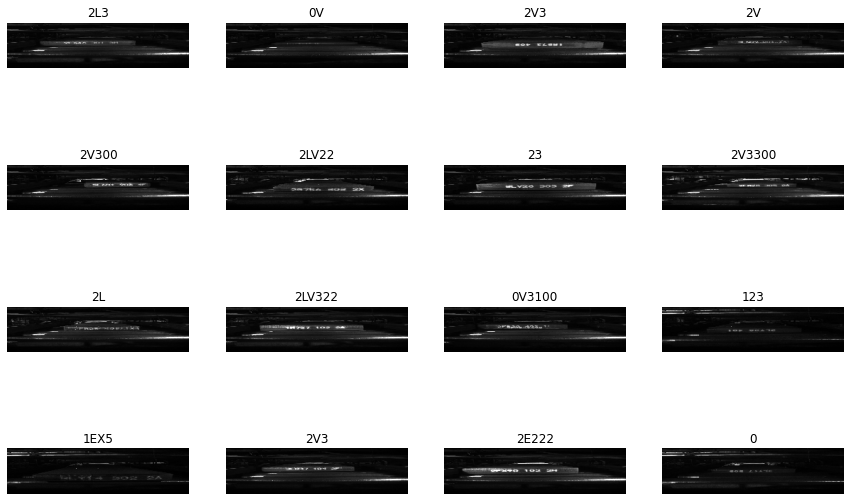

In [27]:
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in test_dataset.take(1):
    images = batch["image"]
    labels = pred_label[:batch_size]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(labels[i])
        ax[i // 4, i % 4].axis("off")
plt.show()

In [170]:
import csv
submission = pd.DataFrame({
    "id": test['filename'],
    "text": pred_label
})
submission.to_csv("./submission_edge_detection.csv", index=False)